<a href="https://colab.research.google.com/github/xuqibai/Delfine-SARIMA/blob/Code/Meckel_1_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure
import numpy as np
import xlrd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product
#import pmdarima as pm
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime

warnings.filterwarnings("ignore")
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive

#drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Delfine Wind Rothenborn/Meckel_1.csv')

In [ ]:
## Convert data into right types
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df

,datetime,power,wind_speed,wind_direction,temperature
0,2019-02-13 12:30:00,-0.003,0.8,233.0,0.101
1,2019-02-13 12:45:00,-0.003,0.8,358.0,0.101
2,2019-02-13 13:00:00,-0.003,0.9,319.0,0.664
3,2019-02-13 13:15:00,-0.003,0.8,290.0,0.664
4,2019-02-13 13:30:00,-0.003,0.8,270.0,0.664
...,...,...,...,...,...
65235,2020-12-21 13:15:00,555.373,7.4,182.0,7.205
65236,2020-12-21 13:30:00,787.080,8.0,183.0,7.205
65237,2020-12-21 13:45:00,567.633,7.3,175.0,7.205
65238,2020-12-21 14:00:00,502.050,7.2,171.0,7.205


In [ ]:
## reset index
df.set_index(df['datetime'], inplace = True)

Long term forcasting (monthly interval)

In [ ]:
## Reform dataframe
monthly_df = df
del monthly_df['wind_speed']
del monthly_df['wind_direction']
del monthly_df['temperature']

monthly_df = monthly_df.resample('M').sum()

monthly_df

,power
datetime,
2019-02-28,192094.956
2019-03-31,1425848.697
2019-04-30,594737.048
2019-05-31,762018.349
2019-06-30,795791.704
2019-07-31,292666.201
2019-08-31,155062.410
2019-09-30,322032.024
2019-10-31,992311.947


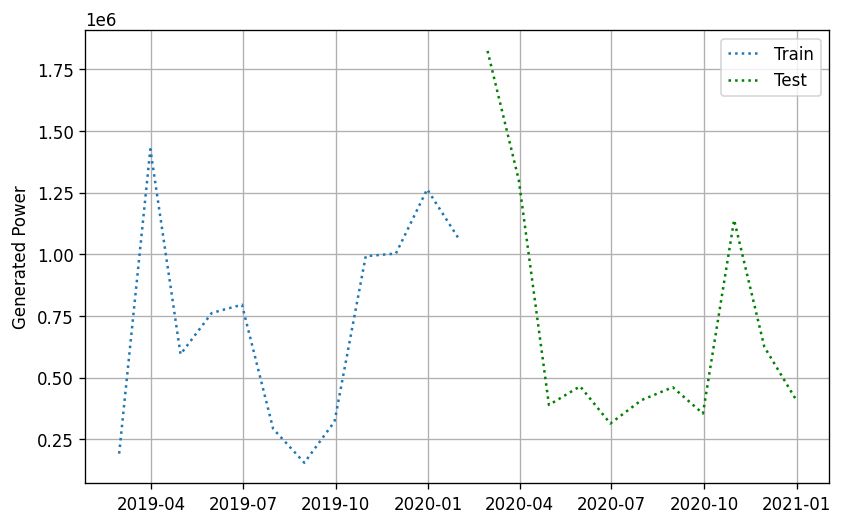

In [ ]:
## Split into training and testing sets

train_horizon = int(12) ## Use 1 year of data to predict the other half year

monthly_train = monthly_df[0:train_horizon]
monthly_test = monthly_df[train_horizon:] ## Renaming the test group because of the confusion after running auto arima function

plt.plot(monthly_train.index.to_pydatetime(), monthly_train, linestyle = 'dotted', label = 'Train')
plt.plot(monthly_test.index.to_pydatetime(), monthly_test, color = 'g', linestyle = 'dotted', label = 'Test')
plt.ylabel('Generated Power')
plt.grid()
plt.legend()
plt.show()

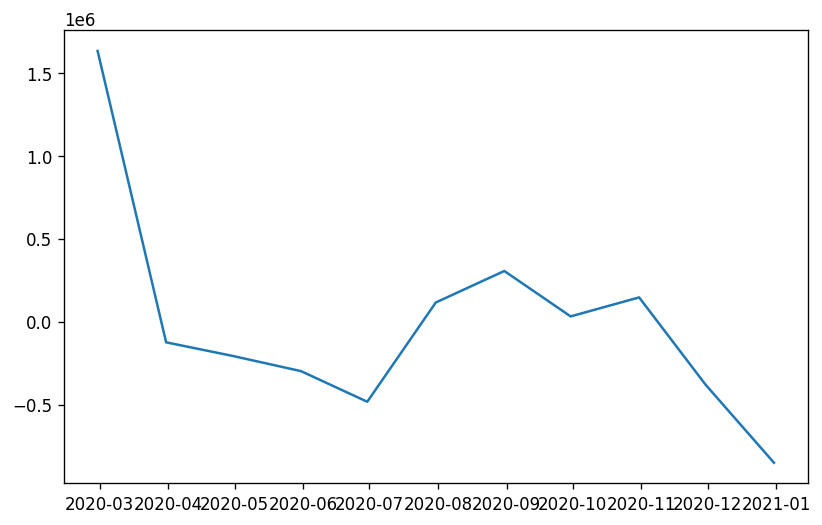

In [ ]:
## Check the appropriate number of time step for a seasonal period
sarima_preview_monthly = monthly_df.diff(12) ## The trend repeats yearly, so period is 52

plt.plot(sarima_preview_monthly)

In [ ]:
## Test stationarity of the data after seasonal differencing

sarima_preview_monthly = sarima_preview_monthly.dropna()
seasonal_dff_test_monthly = adfuller(sarima_preview_monthly['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_monthly = pd.Series(seasonal_dff_test_monthly[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_monthly)

if test_output_monthly[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -1.898224
p value            0.332897
# Lags used        3.000000
# Observation      7.000000
dtype: float64
Null hypothesis is not rejected, the data is not stationary


In [ ]:
## Diff data to make it stationary
diff_1_monthly = sarima_preview_monthly.diff()

diff_1_monthly = diff_1_monthly.dropna()
diff_1_test_monthly = adfuller(diff_1_monthly['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_diff_1_monthly = pd.Series(diff_1_test_monthly[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_diff_1_monthly)

if test_output_monthly[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -1.266836
p value            0.644205
# Lags used        3.000000
# Observation      6.000000
dtype: float64
Null hypothesis is not rejected, the data is not stationary


The monthly data will not become stationary at all, potnetially due to lack of data entries

Long-term forcasting (weekly interval)

In [ ]:
## Reform df
long_df = df 

del long_df['wind_speed']
del long_df['wind_direction']
del long_df['temperature']

In [ ]:
## Resample data
long_df = long_df.resample('W').sum()
long_df

,power
datetime,
2019-02-17,19100.683
2019-02-24,99692.411
2019-03-03,206743.561
2019-03-10,528813.045
2019-03-17,572715.254
...,...
2020-11-29,40824.698
2020-12-06,123201.077
2020-12-13,75845.950


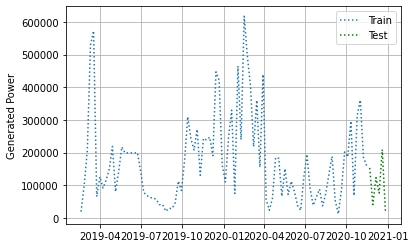

In [ ]:
## Split into training and testing sets

test_horizon = 6 ## Predict for 6 weeks horizon
train_size = int(len(long_df) - test_horizon) 

train_w = long_df[0:train_size]
test_w = long_df[train_size:] ## Renaming the test group because of the confusion after running auto arima function

plt.plot(train_w.index.to_pydatetime(), train_w, linestyle = 'dotted', label = 'Train')
plt.plot(test_w.index.to_pydatetime(), test_w, color = 'g', linestyle = 'dotted', label = 'Test')
plt.ylabel('Generated Power')
plt.grid()
plt.legend()
plt.show()

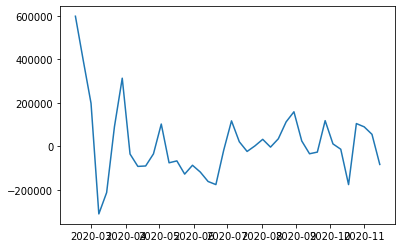

In [ ]:
## Check the appropriate number of time step for a seasonal period
sarima_preview_w = train_w.diff(52) ## The trend repeats yearly, so period is 52

plt.plot(sarima_preview)

In [ ]:
## Test stationarity of the data after seasonal differencing

sarima_preview_w = sarima_preview_w.dropna()
seasonal_dff_test_w = adfuller(sarima_preview_w['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output = pd.Series(seasonal_dff_test_w[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output)

if test_output[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics    -2.569404
p value             0.099487
# Lags used         3.000000
# Observation      36.000000
dtype: float64
Null hypothesis is not rejected, the data is not stationary


In [ ]:
## Diff data to make it stationary
diff_1_w = sarima_preview_w.diff()

diff_1_w = diff_1_w.dropna()
diff_1_test_w = adfuller(diff_1_w['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_diff_1 = pd.Series(diff_1_test_w[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_diff_1)

if test_output[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -1.097584e+01
p value            7.674067e-20
# Lags used        2.000000e+00
# Observation      3.600000e+01
dtype: float64
Reject null hypothesis, the data is stationary


In [ ]:
## Test stationarity of the training data
train_test_w = adfuller(train_w['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_train_w = pd.Series(train_test_w[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_train_w)

if test_output[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics    -4.140811
p value             0.000829
# Lags used         1.000000
# Observation      90.000000
dtype: float64
Reject null hypothesis, the data is stationary


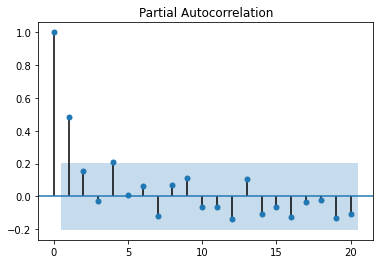

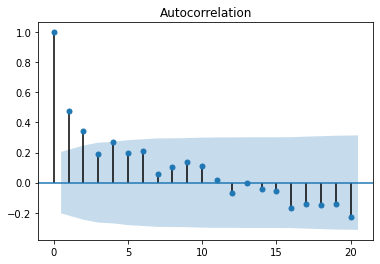

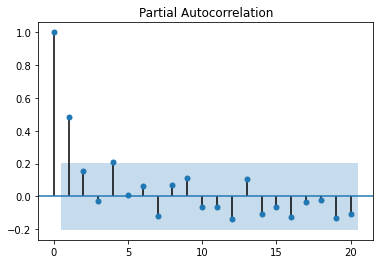

In [ ]:
## Plot to identify p, q parameters
plot_acf(train_w)
plot_pacf(train_w)

p = 1, d = 0, q = 2

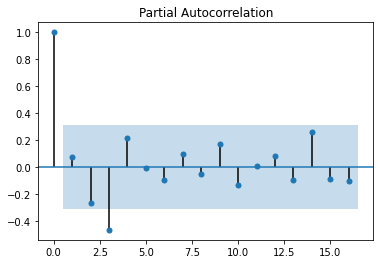

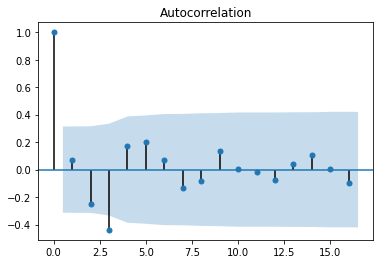

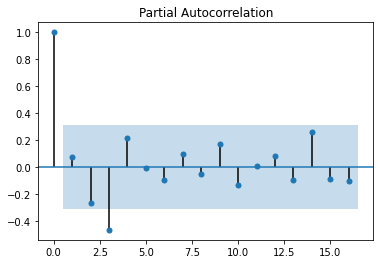

In [ ]:
## Manually identify the seasonal parameters
plot_acf(diff_1_w)
plot_pacf(diff_1_w)

P = 0, D = 1, Q = 0, m = 52

In [ ]:
## Build model 
sarima_mod_w = sm.tsa.statespace.SARIMAX(train_w['power'], order=(1,0,2), seasonal_order=(0,1,0,52)) 
sarima_result_w = sarima_mod_w.fit()
sarima_result_w.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                   92
Model:             SARIMAX(1, 0, 2)x(0, 1, 0, 52)   Log Likelihood                -531.524
Date:                            Fri, 22 Jan 2021   AIC                           1071.047
Time:                                    17:06:56   BIC                           1077.803
Sample:                                02-17-2019   HQIC                          1073.490
                                     - 11-15-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1294      0.098     -1.316      0.188      -0.322       0.063
ma.L1          0.8945      0.054     16.586      0.000       0.789       1.000
ma.L2          0.6899      0.040     17.325      0.000       0.612       0.768
sigma2      6.675e+09   8.94e-13   7.47e+21      0.000    6.68e+09    6.68e+09
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 2.27
Prob(Q):                               nan   Prob(JB):                         0.32
Heteroskedasticity (H):               0.21   Skew:                             0.42
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+40. Standard errors may be unstable.
"""

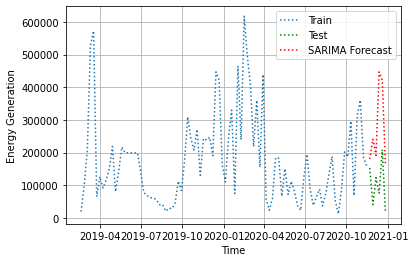

In [ ]:
## Evaluating the model by comparing predicted values and test dataset

sarima_forecast_w = sarima_result_w.predict(train_size, len(long_df)-1, typ = 'levels', dynamic = False) ## Predict for the same period of test dataset

sarima_mse_w = mean_squared_error(test_w, sarima_forecast_w)
model_comparison = list()
model_comparison.append(['SARIMA Weekly', sarima_mse_w])

plt.plot(train_w.index.to_pydatetime(), train_w, label ='Train', linestyle = 'dotted')
plt.plot(test_w.index.to_pydatetime(), test_w, label = 'Test', color = 'g', linestyle = 'dotted')
plt.plot(sarima_forecast_w.index.to_pydatetime(), sarima_forecast_w, label = 'SARIMA Forecast', color = 'r', linestyle = 'dotted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Generation')
plt.grid()
plt.show()

In [ ]:
## Rolling prediction for SARIMA
def rolling_forecast_function_sarima(train_set, test_set, p, d, q, P, D, Q, m, y_label):
    rolling_sarima_predictions = list()
    for train_end in test_set.index:
        train_data = df[:train_end-datetime.timedelta(days=1)]
        rolling_model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=(p,d,q), seasonal_order=(P,D,Q,m)) 
        rolling_model_sarima_fit = rolling_model_sarima.fit()
        rolling_sarima_pred = rolling_model_sarima_fit.forecast()
        rolling_sarima_yhat = rolling_sarima_pred[0]
        rolling_sarima_predictions.append(rolling_sarima_yhat)
    rolling_sarima_predictions = pd.Series(rolling_sarima_predictions, index = test_set.index)
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twiny()
    #ax1.plot(test_group, linestyle = 'dotted', color = 'green', label = 'Test Data') ## plot 1 
    #ax2.plot(rolling_sarima_predictions, linestyle = '-', color = 'red', label = 'Rolling Prediction') ## plot 2
    #ax1.set_xlabel('Time Series')
    #ax1.set_ylabel(y_label)
    plt.plot(rolling_sarima_predictions.index.to_pydatetime(), rolling_sarima_predictions, color = 'red', label = 'SARIMA Rolling Prediction')
    plt.plot(test_set.index.to_pydatetime(),test_set, color = 'green', linestyle ='dotted', label = 'Test')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
    rolling_sarima_predictions = np.nan_to_num(rolling_sarima_predictions)
    check_element = 0
    if check_element in rolling_sarima_predictions:
        print('NaN value exist in prediction, can not calculate RMSE')
        rolling_sarima_mse = float('nan')
    else:
        rolling_sarima_mse = mean_squared_error(test_set, rolling_sarima_predictions)
        print('RMSE for Rolling Prediction:', rolling_sarima_mse)
        return rolling_sarima_mse
    return rolling_sarima_mse

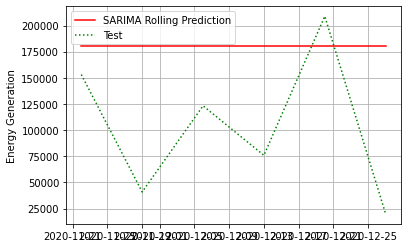

RMSE for Rolling Prediction: 10147323288.53104


In [ ]:
rolling_forecast_function_sarima(train_w, test_w, 1,0,2,0,1,0,52,'Energy Generation')
model_comparison.append(rolling_forecast_function_sarima)

Short-term (15-min interval)

In [ ]:
## Take only 1 month of data 

no_entries = 30 * 24 * 4 ## 15 days, 24 hours per day, 4 entries per hour
short_df = df[len(df) - no_entries:]
del short_df['datetime']
del short_df['wind_speed']
del short_df['wind_direction']
del short_df['temperature']
short_df

,power
datetime,
2020-11-21 14:30:00,134.255
2020-11-21 14:45:00,133.853
2020-11-21 15:00:00,207.080
2020-11-21 15:15:00,163.683
2020-11-21 15:30:00,93.674
...,...
2020-12-21 13:15:00,555.373
2020-12-21 13:30:00,787.080
2020-12-21 13:45:00,567.633


In [ ]:
## Split into train and test

training_ratio = 0.9
train_size = int(len(short_df)*training_ratio) ## Use half of the data to train the model

train_short = short_df[0:train_size]
test_short = short_df[train_size:] ## Renaming the test group because of the confusion after running auto arima function


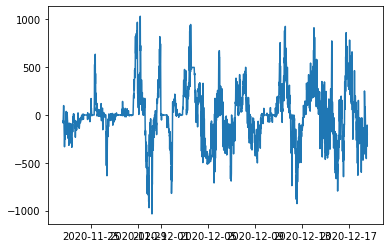

In [ ]:
## Check the appropriate number of time step for a seasonal period
sarima_preview_short = train_short['power'].diff(96) ## As the trend repeats daily, the sesonal period is every 24 hours

plt.plot(sarima_preview_short)

In [ ]:
## Test stationarity of the data after seasonal differencing

sarima_preview_short = sarima_preview_short.dropna()
seasonal_dff_test_short = adfuller(sarima_preview_short, autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output = pd.Series(seasonal_dff_test_short[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output)

if test_output[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -6.402927e+00
p value            1.975077e-08
# Lags used        4.000000e+00
# Observation      2.491000e+03
dtype: float64
Reject null hypothesis, the data is stationary


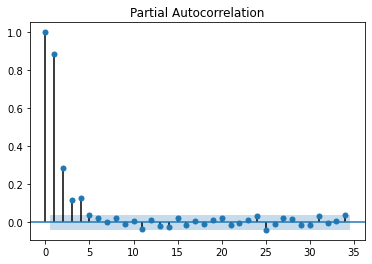

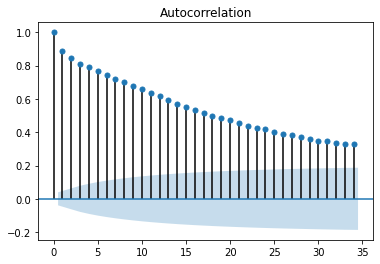

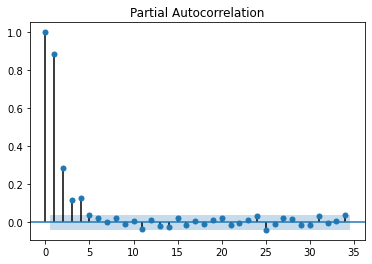

In [ ]:
## Plot the ACF and PACF to identify seasonal parameters 

plot_acf(sarima_preview_short)
plot_pacf(sarima_preview_short)

P = 4, Q = 0, D=0, m = 96


In [ ]:
## Test stationarity of the training model

seasonal_dff_test_train_short = adfuller(train_short['power'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_train_short = pd.Series(seasonal_dff_test_train_short[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_train_short)

if test_output_train_short[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -6.381775e+00
p value            2.213267e-08
# Lags used        4.000000e+00
# Observation      2.587000e+03
dtype: float64
Reject null hypothesis, the data is stationary


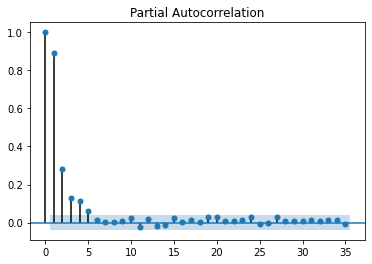

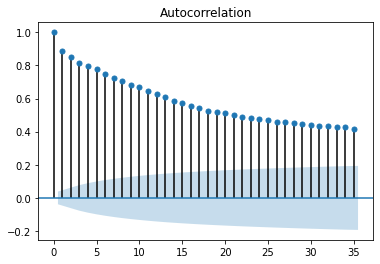

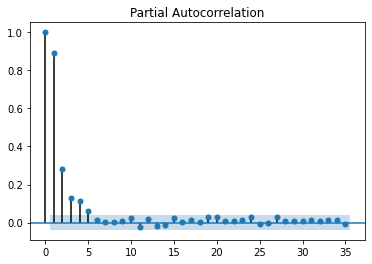

In [ ]:
plot_acf(train_short)
plot_pacf(train_short)

p = 5, d = 0, q = 0

In [ ]:
  ## Fit model with the parameters identified from graphs
  sarima_mod = sm.tsa.statespace.SARIMAX(train_short['power'], order=(5,0,0), seasonal_order=(4,0,0,96)) 
  sarima_result = sarima_mod.fit()
  sarima_result.summary()


In [ ]:
## Rolling prediction for SARIMA
def rolling_forecast_function_sarima(train_set, test_set, p, d, q, P, D, Q, m, y_label):
    rolling_sarima_predictions = list()
    for train_end in test_set.index:
        train_data = df[:train_end-datetime.timedelta(days=1)]
        rolling_model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=(p,d,q), seasonal_order=(P,D,Q,m)) 
        rolling_model_sarima_fit = rolling_model_sarima.fit()
        rolling_sarima_pred = rolling_model_sarima_fit.forecast()
        rolling_sarima_yhat = rolling_sarima_pred[0]
        rolling_sarima_predictions.append(rolling_sarima_yhat)
    rolling_sarima_predictions = pd.Series(rolling_sarima_predictions, index = test_set.index)
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twiny()
    #ax1.plot(test_group, linestyle = 'dotted', color = 'green', label = 'Test Data') ## plot 1 
    #ax2.plot(rolling_sarima_predictions, linestyle = '-', color = 'red', label = 'Rolling Prediction') ## plot 2
    #ax1.set_xlabel('Time Series')
    #ax1.set_ylabel(y_label)
    plt.plot(rolling_sarima_predictions.index.to_pydatetime(), rolling_sarima_predictions, color = 'red', label = 'SARIMA Rolling Prediction')
    plt.plot(test_set.index.to_pydatetime(),test_set, color = 'green', linestyle ='dotted', label = 'Test')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
    rolling_sarima_predictions = np.nan_to_num(rolling_sarima_predictions)
    check_element = 0
    if check_element in rolling_sarima_predictions:
        print('NaN value exist in prediction, can not calculate RMSE')
        rolling_sarima_mse = float('nan')
    else:
        rolling_sarima_mse = mean_squared_error(test_set, rolling_sarima_predictions)
        print('RMSE for Rolling Prediction:', rolling_sarima_mse)
        return rolling_sarima_mse
    return rolling_sarima_mse

In [ ]:
rolling_forecast_function_sarima(train_short, test_short, 5, 0, 0, 4, 0, 0, 96, 'Wind Power Generation')